In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbr

from scipy.stats import pearsonr, kstest, norm

sbr.set(rc={'figure.figsize':[15, 10]})
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
%matplotlib inline

dataset = pd.read_csv("/home/rami/hdd/multivariable_analysis/kc_house_data.csv")

target = 'price'
predictors = ['sqft_living', 'bedrooms', 'bathrooms', 'grade', 'sqft_living15', 'sqft_above']


dataset = dataset.drop(dataset.loc[dataset.price > 3430000.0].index)

data = dataset[ ['price', 'sqft_living', 'bedrooms', 'bathrooms', 'grade', 'sqft_living15', 'sqft_above'] ]
data.head()

,price,sqft_living,bedrooms,bathrooms,grade,sqft_living15,sqft_above
0,221900.0,1180,3,1.00,7,1340,1180
1,538000.0,2570,3,2.25,7,1690,2170
2,180000.0,770,2,1.00,6,2720,770
3,604000.0,1960,4,3.00,7,1360,1050
4,510000.0,1680,3,2.00,8,1800,1680


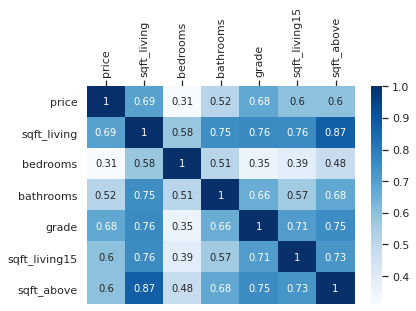

In [55]:
corr = data.corr()
sbr.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap = 'Blues', annot=True,).xaxis.tick_top()
plt.xticks(rotation=90)
plt.show()

In [66]:
mutual_corr = pd.DataFrame(index=data.columns, columns=data.columns)
for label in data.columns:
    mutual_corr.at[label, label] = 1

for key_i in data.columns:
    x = data[key_i].apply(lambda x: float(x))
    for key_j in data.columns:
        if key_i == key_j: continue

        y = data[key_j].apply(lambda x: float(x))
        r, p = pearsonr(x,y)
        r_z = np.arctanh(r)

        se = 1/np.sqrt(x.size-3)
        alpha = 0.05
        z = norm.ppf(1-alpha/2)
        lo_z, hi_z = r_z-z*se, r_z+z*se
        
        mutual_corr.at[key_i, key_j] = f'{lo_z:.3f} - {hi_z:.3f}'
        
mutual_corr

,price,sqft_living,bedrooms,bathrooms,grade,sqft_living15,sqft_above
price,1,0.843 - 0.869,0.310 - 0.336,0.562 - 0.588,0.813 - 0.840,0.679 - 0.705,0.677 - 0.704
sqft_living,0.843 - 0.869,1,0.647 - 0.673,0.960 - 0.987,0.984 - 1.011,0.977 - 1.004,1.338 - 1.364
bedrooms,0.310 - 0.336,0.647 - 0.673,1,0.555 - 0.582,0.357 - 0.384,0.398 - 0.425,0.505 - 0.532
bathrooms,0.562 - 0.588,0.960 - 0.987,0.555 - 0.582,1,0.781 - 0.807,0.627 - 0.654,0.816 - 0.843
grade,0.813 - 0.840,0.984 - 1.011,0.357 - 0.384,0.781 - 0.807,1,0.876 - 0.903,0.967 - 0.993
sqft_living15,0.679 - 0.705,0.977 - 1.004,0.398 - 0.425,0.627 - 0.654,0.876 - 0.903,1,0.918 - 0.944
sqft_above,0.677 - 0.704,1.338 - 1.364,0.505 - 0.532,0.816 - 0.843,0.967 - 0.993,0.918 - 0.944,1


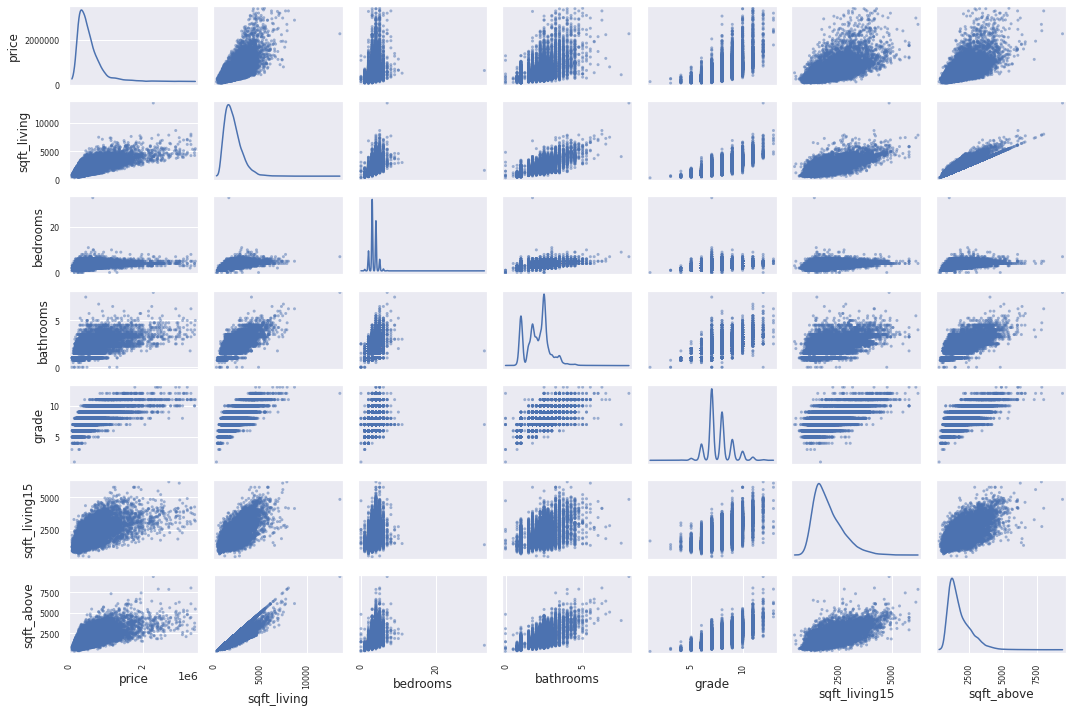

In [3]:
pd.plotting.scatter_matrix(data, diagonal="kde", figsize=(15,10))
plt.tight_layout()
plt.show()

/home/rami/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


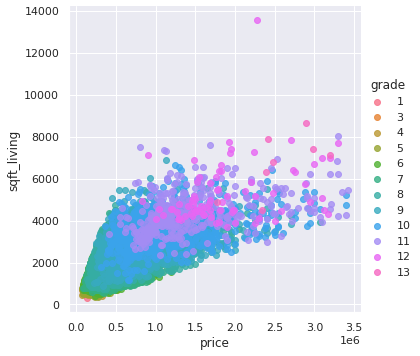

In [4]:
sbr.lmplot("price", "sqft_living", data, hue="grade", fit_reg=False)
plt.show()

In [5]:
print('Target variable mean: ', data[target].mean())
print('Target variable var: ', data[target].var())

Target variable mean:  535926.0251030521
Target variable var:  116416692470.77148


In [27]:
pd.concat([data[predictors].mean().to_frame(name='mean'), data[predictors].var().to_frame(name='var')], axis=1)

,mean,var
sqft_living,2074.776203,814662.703224
bedrooms,3.369413,0.863157
bathrooms,2.111725,0.582894
grade,7.652587,1.364291
sqft_living15,1984.690797,466458.221202
sqft_above,1784.588393,669915.196899


In [24]:
data[predictors].var().to_frame(name='var')

,var
sqft_living,814662.703224
bedrooms,0.863157
bathrooms,0.582894
grade,1.364291
sqft_living15,466458.221202
sqft_above,669915.196899


In [8]:
def calcWithinGroupsCovariance(variable1, variable2, groupvariable):
    levels = sorted(set(groupvariable))
    numlevels = len(levels)
    Covw = 0.0
    # get the covariance of variable 1 and variable 2 for each group:
    for leveli in levels:
        levelidata1 = variable1[groupvariable==leveli]
        levelidata2 = variable2[groupvariable==leveli]
        mean1 = np.mean(levelidata1)
        mean2 = np.mean(levelidata2)
        levelilength = len(levelidata1)
        # get the covariance for this group:
        term1 = 0.0
        for levelidata1j, levelidata2j in zip(levelidata1, levelidata2):
            term1 += (levelidata1j - mean1)*(levelidata2j - mean2)
        Cov_groupi = term1 # covariance for this group
        Covw += Cov_groupi
    totallength = len(variable1)
    Covw /= totallength - numlevels
    return Covw

In [9]:
calcWithinGroupsCovariance(data.sqft_living, data.sqft_living15, data.price)

183283.2743670119

In [10]:
def calcBetweenGroupsCovariance(variable1, variable2, groupvariable):
    # find out how many values the group variable can take
    levels = sorted(set(groupvariable))
    numlevels = len(levels)
    # calculate the grand means
    variable1mean = np.mean(variable1)
    variable2mean = np.mean(variable2)
    # calculate the between-groups covariance
    Covb = 0.0
    for leveli in levels:
        levelidata1 = variable1[groupvariable==leveli]
        levelidata2 = variable2[groupvariable==leveli]
        mean1 = np.mean(levelidata1)
        mean2 = np.mean(levelidata2)
        levelilength = len(levelidata1)
        term1 = (mean1 - variable1mean) * (mean2 - variable2mean) * levelilength
        Covb += term1
    Covb /= numlevels - 1
    return Covb

In [11]:
calcBetweenGroupsCovariance(data.sqft_living, data.sqft_living15, data.price)

1712122.2791955003

In [12]:
pearsonr(data.bedrooms, data.grade)

(0.35426259412075306, 0.0)

In [13]:
pearsonr(data.sqft_living, data.sqft_living15)

(0.7576140586928729, 0.0)

In [14]:
pearsonr(data.sqft_living, data.bedrooms)

(0.5783710479282425, 0.0)

In [15]:
def plotConditionalGrade(data, rows=3):
    
    x = data.grade.unique()
    x.sort()
    y = []

    columns = data.columns.to_list()
    columns.remove('grade')
    cols = np.ceil(1.0*len(columns) / rows)
    cols = int(cols)
    
    # Create two subplots and unpack the output array immediately
    f, axes = plt.subplots(rows, cols, sharex=True, figsize=(15, 10))

    for i, label in enumerate(columns): 
        r = i // cols
        c = i % cols
        
        y = []
        for grade in x:
            y.append( data.loc[data.grade == grade][label].mean() )
        
        axes[r, c].set_title(f'Mean[{label}|grade]')
        axes[r, c].plot(x, y)
        
    plt.show()
    
    # Create two subplots and unpack the output array immediately
    f, axes = plt.subplots(rows, cols, sharex=True, figsize=(15, 10))

    for i, label in enumerate(columns): 
        r = i // cols
        c = i % cols
        
        y = []
        for grade in x:
            y.append( data.loc[data.grade == grade][label].var() )
        
        axes[r, c].set_title(f'Var[{label}|grade]')
        axes[r, c].plot(x, y)
        
    plt.show()

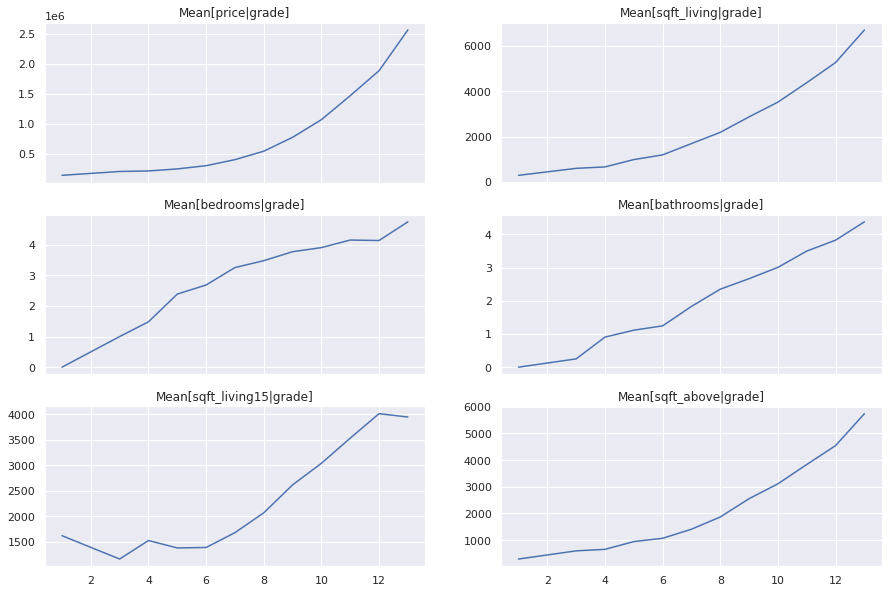

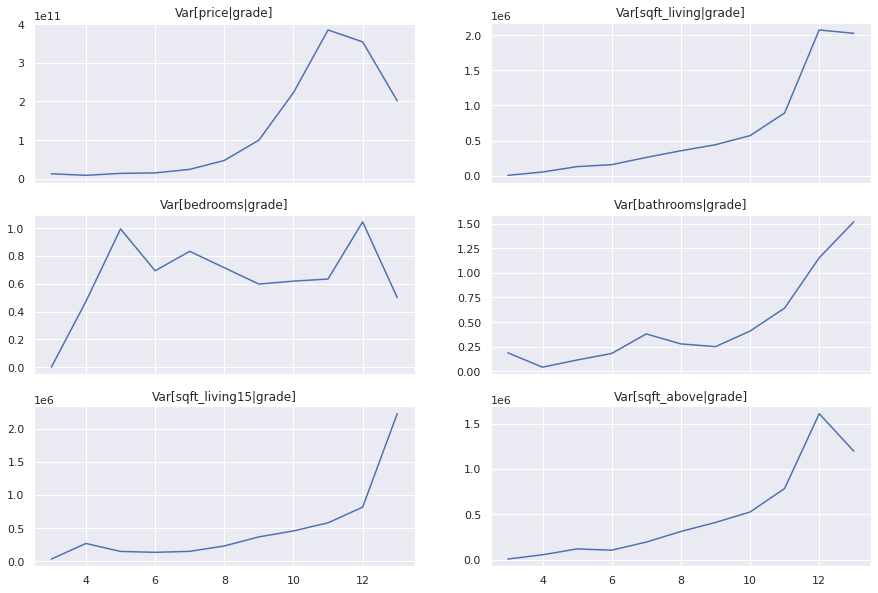

In [16]:
plotConditionalGrade(data)

In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn import metrics

def collect_metrics(y_true, y_pred):
    metric = dict()
    
    metric['mae'] = metrics.mean_absolute_error(y_true, y_pred)
    metric['mse'] = metrics.mean_squared_error(y_true, y_pred)
    metric['mape'] = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    metric['r2'] = metrics.r2_score(y_true, y_pred)
    
    
    for name, value in metric.items():
        print(f'{name}: {value}')

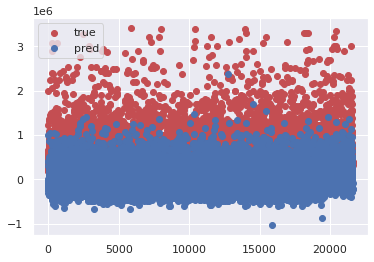

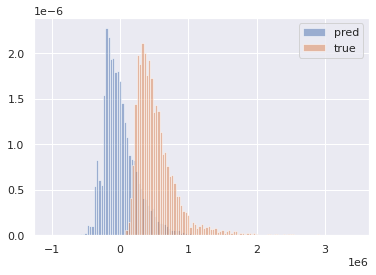

Pearson:     (0.7431768958900371, 0.0)
Kolmogorov:  KstestResult(statistic=0.35, pvalue=7.850159128072286e-06)
mae: 536485.816518215
mse: 339332658514.8424
mape: 120.77630474018115
r2: -1.9149460308004267


In [50]:
X = data[predictors]
Y = data[target]

model = OLS(Y,X)
results = model.fit()
results.summary()

y_pred = results.predict(X)
plt.scatter(range(data.shape[0]), data[target], color='r', marker='o', label='true')
plt.scatter(range(data.shape[0]), y_pred, color='b', marker='o', label='pred')
plt.legend(loc='best')
plt.show()

plt.hist(y_pred, bins=100, density=True, alpha=0.5, label='pred')
plt.hist(data[target], bins=100, density=True, alpha=0.5, label='true')
plt.legend(loc='best')
plt.show()

init_distribution, buckets = np.histogram(Y, bins=100, density=True)
regr_distribution, buckets = np.histogram(y_pred, bins=100, density=True)

print("Pearson:    ", pearsonr(data[target], y_pred))
print("Kolmogorov: ", kstest(regr_distribution, init_distribution))

collect_metrics(Y, y_pred)


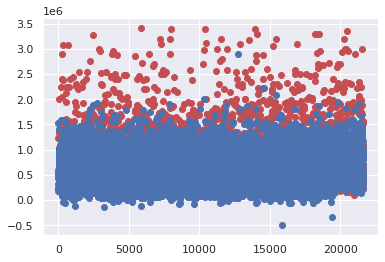

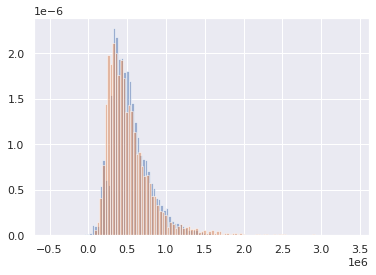

Pearson:     (0.7431768958900371, 0.0)
Kolmogorov:  KstestResult(statistic=0.35, pvalue=7.850159128072286e-06)
mae: 154527.7259621339
mse: 52115954132.08506
mape: 32.15289571311538
r2: 0.5523118985847522


In [52]:
X = data[predictors]
Y = data[target]

sc = StandardScaler().fit(X)
X = sc.transform(X)

reg = LinearRegression().fit(X, Y)

y_pred = reg.predict(X)
plt.scatter(range(data.shape[0]), data[target], color='r', marker='o')
plt.scatter(range(data.shape[0]), y_pred, color='b', marker='o')
plt.show()

plt.hist(y_pred, bins=100, density=True, alpha=0.5)
plt.hist(data[target], bins=100, density=True, alpha=0.5)
plt.show()

init_distribution, buckets = np.histogram(Y, bins=100, density=True)
regr_distribution, buckets = np.histogram(y_pred, bins=100, density=True)

print("Pearson:    ", pearsonr(data[target], y_pred))
print("Kolmogorov: ", kstest(regr_distribution, init_distribution))

collect_metrics(Y, y_pred)

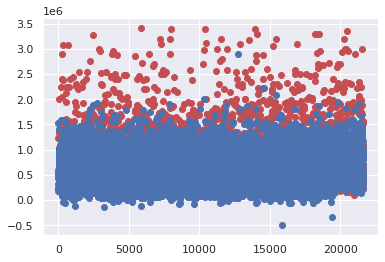

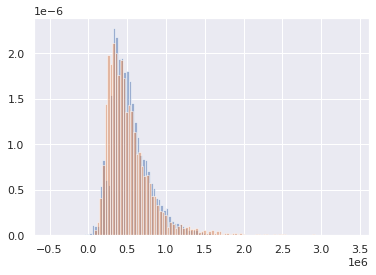

Pearson:     (0.7431768958900369, 0.0)
Kolmogorov:  KstestResult(statistic=0.35, pvalue=7.850159128072286e-06)
mae: 154527.72596213393
mse: 154527.72596213393
mape: 32.152895713115385
r2: 0.5523118985847522


In [32]:
X = data[predictors]
Y = data[target]

reg = LinearRegression(normalize=True).fit(X, Y)
reg.score(X, Y)

y_pred = reg.predict(X)
plt.scatter(range(data.shape[0]), data[target], color='r', marker='o')
plt.scatter(range(data.shape[0]), y_pred, color='b', marker='o')
plt.show()

plt.hist(y_pred, bins=100, density=True, alpha=0.5)
plt.hist(data[target], bins=100, density=True, alpha=0.5)
plt.show()

init_distribution, buckets = np.histogram(Y, bins=100, density=True)
regr_distribution, buckets = np.histogram(y_pred, bins=100, density=True)

print("Pearson:    ", pearsonr(data[target], y_pred))
print("Kolmogorov: ", kstest(regr_distribution, init_distribution))

collect_metrics(Y, y_pred)